In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   IPython.display import display, HTML
from collections import deque
import random
import os
import sys
import pathlib
from collections import deque
from tqdm.notebook import tqdm, trange
import datetime
from scipy import interpolate
import math

import matplotlib.ticker as mtick
import matplotlib.dates as md

from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md

In [2]:
parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)

In [3]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [4]:
def get_LOB_data(data_path, asset_name, trade_date):
    LOB_data_path = os.path.join(data_path, asset_name, f'{asset_name}_{trade_date}_34200000_57600000_orderbook_5.csv')
    LOB_data      = pd.read_csv(LOB_data_path,
                                usecols   = [0, 1, 2, 3],
                                engine    = 'c',
                                index_col = None,
                                header    = None,
                                infer_datetime_format = True)

    LOB_messages = pd.read_csv(f'{data_path}/{asset_name}/{asset_name}_{trade_date}_34200000_57600000_message_5.csv', 
                               usecols   = [0,1],
                               engine    = 'c',
                               index_col = 0,
                               header    = None)
    LOB_data.index = LOB_messages.index
    LOB_data.columns = [f'ask_1', f'ask_volume_1', f'bid_1', f'bid_volume_1']
    LOB_data.index.name = 'time'
    LOB_data = LOB_data.reset_index(drop=False).groupby('time').last()
    
    return LOB_data, LOB_messages

# Load Data & Signals

In [5]:
asset_name = 'GOOG'
predictive_power_freq = '500ms'

In [6]:
all_data = None
for filename in os.listdir(f'../data/Rewards'):
    f = os.path.join(f'../data/Rewards', filename)
    # checking if it is a file
    if os.path.isfile(f):
        if asset_name in filename:
            trade_date   = filename.split('_')[1]
            reward_fn    = f'{asset_name}_{trade_date}_rewards.pkl'
            _all_data    = pd.read_pickle(f'../data/Rewards/{reward_fn}')           
            _all_data    = _all_data[~_all_data.index.duplicated()].resample(predictive_power_freq).last().fillna(method='ffill')
            if all_data is None:
                all_data = _all_data
            else:
                all_data = pd.concat((all_data, _all_data), axis=0)
all_data = all_data.sort_index()

In [7]:
np.shape(all_data)

(2603109, 36)

In [8]:
np.mean(np.diff(all_data.index))/1e9

numpy.timedelta64(2,'ns')

In [9]:
# all_data
# all_data.buyPrice_TF.dropna()
# all_data
print('Average Bid Ask spread : ', all_data.ba_spread.mean())

Average Bid Ask spread :  0.014910501250619927


# GP bandits

In [10]:
from AOE.utils import verbose_print
from AOE.bandit_plots import hit_ratio_analysis, reward_distribution_analysis, regret_plots
from AOE.gp_bandit_finance import gp_bandit_finance, Wasserstein_GP_mean#, Wasserstein_GP
from AOE.plots import rescale_plot

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [11]:
strategies  = {'imbalance_1' : {'name'             : 'imbalance_1',
                                     'params'           : {'feature_name'     : 'imbalance_1'},
                                     'contextual_params': {'feature_name'     : 'imbalance_1'}},

               'MR' : {'name'             : 'MR',
                                  'params'           : {'feature_name'     : 'MR'},
                                  'contextual_params': {'feature_name'     : 'MR'}},

               'TF' : {'name'             : 'TF',
                                  'params'           : {'feature_name'     : 'TF'},
                                  'contextual_params': {'feature_name'     : 'TF'}}
              }


strategies  = {'imbalance_1' : {'name'             : 'imbalance_1',
                                'params'           : {'feature_name'     : 'imbalance_1'},
                                'contextual_params': {'feature_name'     : 'imbalance_1'}},

               'MR2' : {'name'            : 'MR2',
                      'params'           : {'feature_name'     : 'MR2'},
                      'contextual_params': {'feature_name'     : 'MR2'}}
              }

In [12]:
features = all_data[[s for s in all_data.columns if (('buyPrice' not in s) & ('sellPrice' not in s))]] 

In [13]:
# Likelihood models & non stationarity params
likelihood              = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise        = 0.0001

size_buffer             = 30 # in terms of number of rewards to sample from
size_buffer_2           = 30 # in terms of number of rewards to sample from
size_window             = 16 # for non statonarity

bandit_params = {'size_buffer': size_buffer_2, 
                 'size_window': size_window,
                 'threshold'  : 0.0005,
                 'lambda'     : 0.6,
                 'delta'      : 0.6} # Delta is bound on type 1 error

# Bandit objects
_bandits = {'GP_UCB_NS'          : gp_bandit_finance(strategies, bandit_algo='UCB_NS', likelihood=likelihood, 
                                                      bandit_params = bandit_params),
            'GP_UCB_WAS'         : gp_bandit_finance(strategies, bandit_algo='UCB_WAS', likelihood=likelihood, 
                                                      bandit_params = bandit_params, reinit=True),
            'GP_UCB_WAS_NOREINIT': gp_bandit_finance(strategies, bandit_algo='UCB_WAS', likelihood=likelihood, 
                                                      bandit_params = bandit_params, reinit=False),
            'GP_UCB_LR'          : gp_bandit_finance(strategies, bandit_algo='UCB_LR', likelihood=likelihood, 
                                                      bandit_params = bandit_params, reinit=True),
            'GP_UCB_LR_NOREINIT' : gp_bandit_finance(strategies, bandit_algo='UCB_LR', likelihood=likelihood, 
                                                      bandit_params = bandit_params, reinit=False),
            'RANDOM'             : gp_bandit_finance(strategies, bandit_algo='RANDOM', likelihood=likelihood, 
                                                      bandit_params = bandit_params),
            'UCB_NS'             : gp_bandit_finance(strategies, bandit_algo='MAB_UCB', likelihood=likelihood, 
                                                      bandit_params = bandit_params)}
           #'TS_ADAGA'      : gp_bandit_finance(strategies, bandit_algo='TS_ADAGA', likelihood=likelihood, 
           #                              bandit_params=bandit_params),
           #'UCB_ADAGA'      : gp_bandit_finance(strategies, bandit_algo='UCB_ADAGA', likelihood=likelihood, 
           #                              bandit_params=bandit_params)}
        
_bandits = {'GP_UCB_LR'          : gp_bandit_finance(strategies, bandit_algo='UCB_LR', likelihood=likelihood, 
                                                      bandit_params = bandit_params, reinit=True),
            'GP_UCB_LR_NOREINIT' : gp_bandit_finance(strategies, bandit_algo='UCB_LR', likelihood=likelihood, 
                                                      bandit_params = bandit_params, reinit=False)}

INTIALIZING!
INTIALIZING!


# Other control parameters and variables

In [14]:
# variables for historical trading data
i_order                   = 0
nb_added_rewards          = {bandit_k:0 for bandit_k in _bandits.keys()}
verbose_level             = 0
arrival_intensity         = 0.5
ref_price                 = 'S0'
nb_orders                 = 0

In [15]:
def init_variables(all_data, _bandits):
    
    bandits = _bandits
    bandit_rewards = pd.DataFrame(index=all_data.index)
    for bandit_k in bandits.keys(): 
        bandit_rewards[bandit_k] = np.nan
    bandit_rewards['oracle'] = np.nan
    for strat in strategies.keys():
        bandit_rewards[strat] = np.nan
    
    batch_times = list(all_data.index)
    # distances   = {bandit_k:{strat: [] for strat in strategies.keys()} for bandit_k in bandits.keys()}

    bandits_fin_info = {bandit_k:pd.DataFrame(index=all_data.index) for bandit_k in bandits.keys()}
    for bandit_k in bandits.keys(): 
        bandits_fin_info[bandit_k]['execPrice'] = np.nan
        bandits_fin_info[bandit_k]['S0']        = np.nan
        bandits_fin_info[bandit_k]['ST']        = np.nan
        bandits_fin_info[bandit_k]['twapPrice'] = np.nan
        
    return bandit_rewards, bandits_fin_info, batch_times, bandits

# Trading simulation

In [16]:
def alpha(gamma, sigma, V, nu, dt):
    cosh_alpha_dt = 1 + (gamma * V * (dt*sigma)**2) / (4 * nu)
    return (1/dt) * np.arccosh(cosh_alpha_dt)

def q_star(x, q0, T, gamma, sigma, V, nu, dt):
    alpha_ = alpha(gamma, sigma, V, nu, dt)
    return q0 * np.sinh(alpha_*(T - x))/np.sinh(alpha_*T)

S0        = 100
sigma     = 5
V         = 15000000 #TransactionTape.set_index('time').traded_quantity.rolling('1h').sum().mean()
nu        = 10 # 0.1 dollar per contract for AC style.
gamma     = 10**1 #per dollar
T         = 5/60/24

timesteps = np.linspace(0, T, 100)
q0        = 100 #int(0.1 * V) # nb of shares to liquidate : 10% of total traded volume
dt        = T/100

In [17]:
nb_simulations    = 1
res_simulations   = {}
programme_horizon = '10min'

#np.random.seed(14)

for i_simul in range(nb_simulations):    
    # choose a random starting point for the programme starting time
    i_start = int(np.random.rand(1)*(9*len(all_data)/10))
    programme_data = all_data.iloc[i_start:].first(programme_horizon)
    
    # Fill na exec prices accordingly
    for col in programme_data.columns:
        if 'Price_' in col:
            programme_data[col].fillna(programme_data[ref_price], inplace=True)
    
    # This also create new bandit objects
    bandit_rewards, bandits_fin_info, batch_times, bandits = init_variables(programme_data, _bandits)
    
    buysell          = 2*np.random.randint(0, 2, size=None, dtype=int)-1
    verbose_print(verbose_level, None, f'I received an order at {None} with quantity {buysell}', True)
    
    q0     = 100*buysell
    q      = np.zeros(len(batch_times)+1)
    q[0]   = q0
    dt     = T/len(batch_times)
    
    for (i_time, batch_time) in enumerate(batch_times): # leave a few minutes
        # if np.random.poisson(arrival_intensity)>0:
        sigma       = 5
        q_cible     = q_star(T * i_time/len(batch_times), q0, T, 10**-3, sigma, V, nu, dt)
        trade_size  = int(q_cible - q[i_time])     
        q[i_time+1] = q[i_time]+trade_size
        V           = 15000000 #TransactionTape.set_index('time').traded_quantity.rolling('1h').sum().mean()
        nb_orders   += 1

#             if ((nb_orders%20==0) & (i_time>0)):
#                 print('************************************ Simul number:', i_simul)
#                 clear_output(wait=True)
#                 verbose_level = 1
#                 for bandit_k in bandits.keys():
#                     bandits[bandit_k].plot_strategies()         

#                 # get historical rewards and regret
#                 rewards_to_plot = pd.DataFrame(index=programme_data.index)
#                 for bandit_k in bandits.keys():
#                     rewards_to_plot[bandit_k] = np.array(bandit_rewards[bandit_k])
#                 for (i_strat, strat) in enumerate(strategies.keys()):
#                     rewards_to_plot[strat]    = np.array(bandit_rewards[strat])
#                 rewards_to_plot = rewards_to_plot.sort_index()
#                 regret_plots(strategies, rewards_to_plot.dropna(), programme_data,  bandits, W=5.5, figure_name = None)
#             else:
#                 verbose_level = 0

        trade_date = str(batch_time).split(' ')[0]

        ###############################################
        # retrain GPs hyperparameters every N orders 
        ###############################################
        retrain_hyperparameters = True

        ##################################################
        # if an order arrives: decide if buy & sell
        ##################################################
        i_order          += 1

        ######################
        # get feature values
        ######################
        feature_values = features.loc[batch_time, :]

        ######################################
        # select the strategy for all bandits
        ######################################
        verbose_print(verbose_level, batch_time, f'Selecting strategies ...')
        best_strategies_bandits = {}
        for bandit_k in bandits.keys():
            verbose_print(verbose_level, batch_time, f'** Bandit {bandit_k}: Selecting strategies ...')
            if i_time < 5*len(strategies): # at least 5 rewards before sampling
                best_strategies_bandits[bandit_k]  = random.choice(list(strategies.keys()))
            else:
                best_strategies_bandits[bandit_k]  = bandits[bandit_k].select_best_strategy(feature_values)
            verbose_print(verbose_level, batch_time, f'Selected strategy: {best_strategies_bandits[bandit_k]}')
        
        ######################################
        # Update & Retrain the GPs
        # & Non stationarity test
        ######################################
        tmp_pnls = {bandit_k:np.nan for bandit_k in bandits.keys()}
        for bandit_k in bandits.keys():
            if buysell == 1:
                tmp_pnls[bandit_k] = -programme_data.loc[batch_time, f'buyPrice_{best_strategies_bandits[bandit_k]}'] + \
                            programme_data.loc[batch_time, ref_price]
            else:
                tmp_pnls[bandit_k] = programme_data.loc[batch_time, f'sellPrice_{best_strategies_bandits[bandit_k]}'] - \
                            programme_data.loc[batch_time, ref_price]
        
        for bandit_k in bandits.keys():
            #print('Adding bandit : ', bandit_k, 'values are:', feature_values.MR, best_strategies_bandits[bandit_k], tmp_pnls[bandit_k])
            try:
                bandits[bandit_k].update_data(features  = feature_values, 
                                              strat     = best_strategies_bandits[bandit_k], 
                                              reward    = tmp_pnls[bandit_k],
                                              retrain_hyperparameters = retrain_hyperparameters)
            except Exception as e:
                retrain_hyperparameters = True
                print('Error while updating the bandit ', bandit_k ,': ', str(e), '\n', tmp_pnls[bandit_k])
                bandits[bandit_k].update_data(features  = feature_values, 
                                              strat     = best_strategies_bandits[bandit_k], 
                                              reward    = tmp_pnls[bandit_k],
                                              retrain_hyperparameters = False)
                #bandits[bandit_k].strat_gp_dict[best_strategies_bandits[bandit_k]].train()

        ######################################
        # Record rewards
        ######################################
        for bandit_k in bandits.keys():
            if buysell == 1:
                bandits_fin_info[bandit_k].loc[batch_time,'execPrice']  = \
                                programme_data.loc[batch_time, f'buyPrice_{best_strategies_bandits[bandit_k]}'] 
            else:
                bandits_fin_info[bandit_k].loc[batch_time,'execPrice']  = \
                                programme_data.loc[batch_time, f'sellPrice_{best_strategies_bandits[bandit_k]}'] 

            bandit_rewards.loc[batch_time, bandit_k]               = tmp_pnls[bandit_k]
            bandits_fin_info[bandit_k].loc[batch_time,'S0']        = programme_data.loc[batch_time, 'S0'] 
            bandits_fin_info[bandit_k].loc[batch_time,'ST']        = programme_data.loc[batch_time, 'ST'] 
            bandits_fin_info[bandit_k].loc[batch_time,'twapPrice'] = programme_data.loc[batch_time, 'twapPrice'] 

        for strat in strategies.keys():
            if buysell == 1:
                bandit_rewards.loc[batch_time, strat] = \
                            -programme_data.loc[batch_time, f'buyPrice_{strat}'] + \
                            programme_data.loc[batch_time, ref_price]
            else:
                bandit_rewards.loc[batch_time, strat] = \
                            programme_data.loc[batch_time, f'sellPrice_{strat}'] - \
                            programme_data.loc[batch_time, ref_price]


        ##############################
        # Record oracle info
        ##############################
        oracle_strategy = bandit_rewards.loc[batch_time, strategies.keys()].idxmax() #(pnls_buy.loc[batch_time]).idxmax()
        bandit_rewards.loc[batch_time, 'oracle'] = bandit_rewards.loc[batch_time, f'{oracle_strategy}']
        verbose_print(verbose_level, batch_time, f"Oracle strategy: {oracle_strategy}")
    
    # multiply pnls by trading speed
    v = np.diff(q)
    for i in range(len(bandit_rewards)):
        bandit_rewards.iloc[i,:] = np.abs(v[i]) * bandit_rewards.iloc[i,:]
    
    res_simulations[i_simul] = buysell, bandit_rewards, bandits_fin_info, q
    
    # verbose
    clear_output(wait=True)
    print('************************************ Simul number:', i_simul)
    
    # prepare the plot
    rescale_plot(8, 10, 3)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, constrained_layout=True)

    # plot programme prices
    ax1.plot(programme_data.index, programme_data.mid_price, color='k', lw=2)

    # get regrets & rewards
    rewards_to_plot = pd.DataFrame(index=programme_data.index)
    for bandit_k in bandits.keys():
        rewards_to_plot[bandit_k] = np.array(bandit_rewards[bandit_k])
    for (i_strat, strat) in enumerate(strategies.keys()):
        rewards_to_plot[strat]    = np.array(bandit_rewards[strat])
    rewards_to_plot = rewards_to_plot.sort_index()
    ax2.plot(rewards_to_plot.index, rewards_to_plot.dropna().cumsum(), lw=2)
    ax2.legend(list(rewards_to_plot.columns), 
           loc='best', fancybox=True, framealpha=0.1, handlelength=0.1)
    df_sim_results = pd.concat( (res_simulations[i][1].dropna().cumsum().iloc[-1] for i in res_simulations.keys()), axis=1).T
    stats_sim = df_sim_results.describe().T
    stats_sim['sharpe'] = stats_sim['mean']/stats_sim['std']
    
    # Some printing
    display(stats_sim.sort_values(by='mean', ascending=False).loc[:, ['count', 'mean', 'std', 'sharpe']])
    for bandit_k in bandits.keys():
        print( bandit_k, ':', round(10000 * stats_sim.loc[bandit_k, 'mean']/bandits_fin_info[bandit_k].execPrice.mean(), 2), "bps" )
    ax3.plot(res_simulations[i_simul][1].dropna().index, q[1:], color='k', lw=2) #np.linspace(len(res_simulations[i_simul][1].dropna()), 0, len(res_simulations[i_simul][1].dropna()))
    for ax in (ax1, ax2, ax3): ax.grid(axis='both'); ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='right')
    plt.show()
    # regret_plots(strategies, rewards_to_plot.dropna(), programme_data,  bandits, W=5.5, figure_name = None)

/Users/faycaldrissi/miniconda/envs/aoe/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/faycaldrissi/miniconda/envs/aoe/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/faycaldrissi/miniconda/envs/aoe/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/faycaldrissi/miniconda/envs/aoe/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/faycaldrissi/miniconda/envs/aoe/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches t

NameError: name 'res_simulations' is not defined

In [ ]:
plt.plot(q[1:50])
plt.grid('both')

# non stationary tests statics

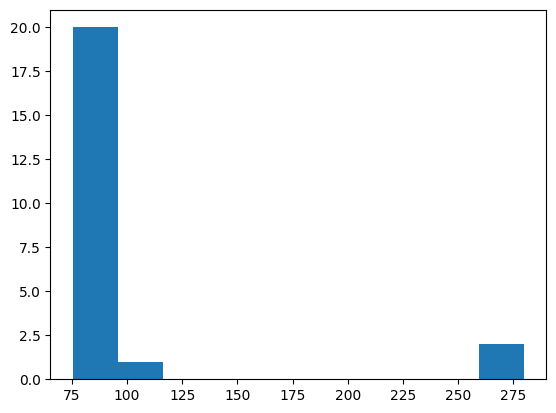

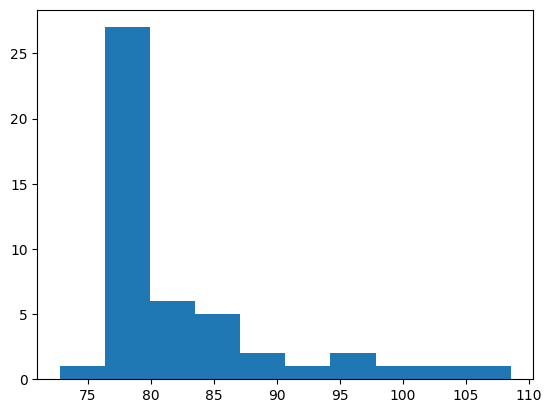

In [61]:
bandit_name = 'GP_UCB_LR'
for strat in strategies.keys():
    lrstats_ = list(bandits[bandit_name].records['lr_statistic'][strat])
    lrstats = [float(i) for i in lrstats]
    
    plt.hist(lrstats)
    plt.show()

# Final stats

In [18]:
for bandit_k in bandits.keys():
    print( bandit_k, ':', round(10000 * stats_sim.loc[bandit_k, 'mean'] / bandits_fin_info[bandit_k].execPrice.mean(), 2), "bps" )

NameError: name 'stats_sim' is not defined

In [30]:
df_sim_results = pd.concat( (res_simulations[i][1].dropna().cumsum().iloc[-1] for i in res_simulations.keys()), axis=1).T
stats_sim = df_sim_results.describe().T
stats_sim['sharpe'] = stats_sim['mean']/stats_sim['std']
stats_sim.sort_values(by='mean', ascending=False).loc[:, ['count', 'mean', 'std', 'sharpe']]

,count,mean,std,sharpe
oracle,104.0,0.207596,0.169636,1.223778
imbalance_1,104.0,0.064231,0.094832,0.677312
GP_UCB_LR_NOREINIT,104.0,0.063750,0.096978,0.657366
GP_UCB_WAS_NOREINIT,104.0,0.062452,0.093958,0.664677
GP_UCB_LR,104.0,0.052981,0.092436,0.573161
GP_UCB_WAS,104.0,0.043750,0.087995,0.497189
RANDOM,104.0,0.039904,0.095307,0.418686
UCB_NS,104.0,0.037115,0.103969,0.356985
GP_UCB_NS,104.0,0.034760,0.091525,0.379781
MR2,104.0,0.006875,0.087982,0.078141


In [20]:
benchs    = ('twapPrice', 'S0', 'ST')

for bandit_k in bandits.keys():
    print('\n', '***********', bandit_k, '***********')
    n          = len(res_simulations)
    for bench in benchs:
        pnl_bandit = 0
        pnl_twap   = 0
        pnl_execS0 = 0
        pnl_execST = 0
        for i in range(n):
            tmp_bandit   = res_simulations[i][2][bandit_k].dropna()
            pnl_bandit   += res_simulations[i][0] * (-tmp_bandit.execPrice.mean() + tmp_bandit[bench].mean())
            #tmp_bandit.execPrice.sum() - tmp_bandit[bench].sum()
            # pnl_twap     += tmp_bandit.twapPrice.sum() - len(tmp_bandit)*tmp_bandit.iloc[0][bench]
            # pnl_execS0   += tmp_bandit.S0.sum()        - len(tmp_bandit)*tmp_bandit.iloc[0][bench]
            # pnl_execST   += tmp_bandit.ST.sum()        - len(tmp_bandit)*tmp_bandit.iloc[0][bench]
    
        print('PNL when bench =', bench, ':', round(pnl_bandit, 3))
# res_simulations[i][1]['TS_WAS'].dropna().S0.sum()


 *********** GP_UCB_NS ***********
PNL when bench = twapPrice : 0.061
PNL when bench = S0 : 0.054
PNL when bench = ST : 0.076

 *********** GP_UCB_WAS ***********
PNL when bench = twapPrice : 0.085
PNL when bench = S0 : 0.078
PNL when bench = ST : 0.1

 *********** GP_UCB_WAS_NOREINIT ***********
PNL when bench = twapPrice : 0.087
PNL when bench = S0 : 0.08
PNL when bench = ST : 0.102

 *********** GP_UCB_LR ***********
PNL when bench = twapPrice : 0.063
PNL when bench = S0 : 0.056
PNL when bench = ST : 0.078

 *********** GP_UCB_LR_NOREINIT ***********
PNL when bench = twapPrice : 0.065
PNL when bench = S0 : 0.058
PNL when bench = ST : 0.079

 *********** RANDOM ***********
PNL when bench = twapPrice : 0.066
PNL when bench = S0 : 0.058
PNL when bench = ST : 0.08

 *********** UCB_NS ***********
PNL when bench = twapPrice : 0.058
PNL when bench = S0 : 0.051
PNL when bench = ST : 0.072


In [21]:
# fig, axes = plt.subplots(2, 3, sharey=True)
# for (i_i, bandit_k) in enumerate(bandits.keys()):
#     for (i_j, strat) in enumerate(strategies):
#         axes[i_i, i_j].plot(distances[bandit_k][strat])
#         axes[i_i, i_j].set_title(f'bandit {bandit_k}\n strat {strat}')
#         axes[i_i, i_j].grid(axis='both')
# plt.tight_layout()

# Regret analysis

In [22]:
# get historical rewards and regret
rewards_to_plot = pd.DataFrame(index = all_data.index)
regrets_to_plot = pd.DataFrame(index = all_data.index)

for bandit_k in bandits.keys(): regrets_to_plot[bandit_k] = np.nan
for (i_strat, strat) in enumerate(strategies.keys()): regrets_to_plot[strat] = np.nan
    
for i_simul in range(nb_simulations):
    buysell, bandit_rewards, bandits_fin_info, q = res_simulations[i_simul]
    
    for bandit_k in bandits.keys():
        regrets_to_plot.loc[bandit_rewards.index, bandit_k] = - np.array(bandit_rewards[bandit_k]) + np.array(bandit_rewards['oracle'])
        rewards_to_plot.loc[bandit_rewards.index, bandit_k] = np.array(bandit_rewards[bandit_k])
        
    for (i_strat, strat) in enumerate(strategies.keys()):
        regrets_to_plot.loc[bandit_rewards.index, strat]    = - np.array(bandit_rewards[strat])  + np.array(bandit_rewards['oracle'])
        rewards_to_plot.loc[bandit_rewards.index, strat]    = np.array(bandit_rewards[strat])

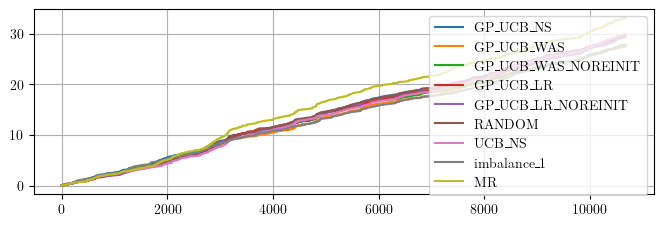

In [23]:
regrets_to_plot.cumsum().sort_index().dropna().reset_index(drop=True).plot()
plt.grid('both')
plt.show()

### Hit ratio

In [24]:
# (bandit_rewards.dropna()['UCB']==bandit_rewards.dropna()['oracle']).sum()/len(bandit_rewards.dropna())

In [25]:
hit_ratio_analysis(rewards_to_plot, bandit_rewards['oracle'], bandits, _W = 5.5)

Global number of rewards for every bandit: 260327
Hit ratio GP_UCB_NS: 1 %
Hit ratio GP_UCB_WAS: 1 %
Hit ratio GP_UCB_WAS_NOREINIT: 1 %
Hit ratio GP_UCB_LR: 1 %
Hit ratio GP_UCB_LR_NOREINIT: 1 %
Hit ratio RANDOM: 1 %
Hit ratio UCB_NS: 1 %


### Reward distributions

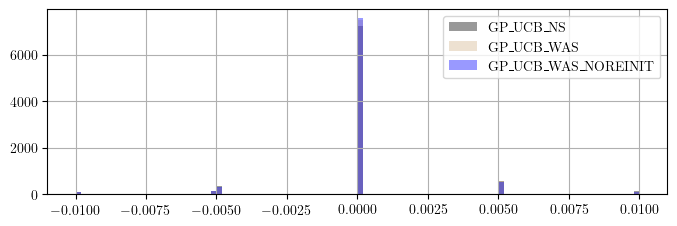

In [26]:
for (clr, bandit_k) in zip(('k', 'tan', 'blue'), bandits.keys()):
    rewards_to_plot[bandit_k][rewards_to_plot[bandit_k].abs()<0.01].hist(bins=100,  color=clr, alpha=0.4, density=False)
plt.legend(bandits.keys())

### Reward distributions in time

KeyError: 'UCB_WAS'

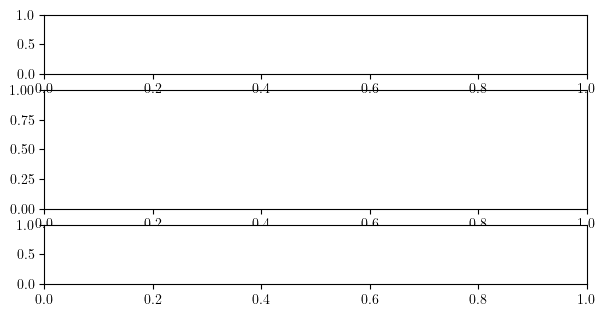

In [27]:
period_est  = 20 # in number of rewards, can be "10min"
bandit_name = 'UCB_WAS'

bandit_rewards  = pd.concat((res_simulations[i_simul][1] for i_simul in range(nb_simulations)), axis=0)

reward_distribution_analysis(bandit_name, bandits, period_est, all_data.loc[bandit_rewards.index,:], rewards_to_plot.loc[bandit_rewards.index,:].cumsum(), bandit_rewards,
                              strategies, W = 7, figure_name = None)

### Regret plots

In [ ]:
regret_plots(strategies, regrets_to_plot.dropna(), all_data,  bandits, W=5.5, figure_name = None)

In [ ]:
regret_plots(strategies, rewards_to_plot.dropna(), all_data,  bandits, W=5.5, figure_name = None)

### GP plot

In [ ]:
bandit_name  = 'UCB_WAS'
bandits[bandit_name].plot_strategies()